## Importing the required libraries

In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

/home/therochvoices/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/therochvoices/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
from keras import regularizers

In [3]:
import os

In [150]:
mylist= os.listdir('RawData/')

In [151]:
type(mylist)

list

In [152]:
len(mylist)

1072

In [153]:
print(mylist[1000])

03-02-06-01-01-02-02.wav


In [154]:
print(mylist[400][6:-16])

03


## Plotting the audio file's waveform and its spectrogram

In [155]:
data, sampling_rate = librosa.load('RawData/03-02-01-01-01-01-01.wav')

Populating the interactive namespace from numpy and matplotlib


/home/therochvoices/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test', 'shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


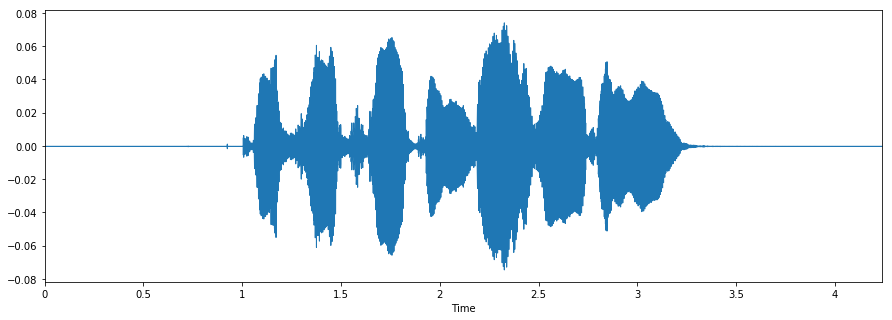

In [156]:
% pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

/home/therochvoices/.local/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
/home/therochvoices/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log


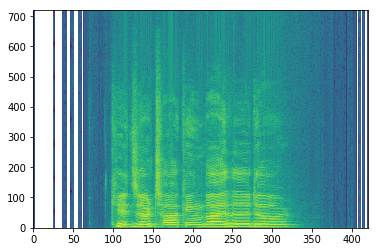

In [157]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys


sr,x = scipy.io.wavfile.read('RawData/03-02-01-01-01-01-01.wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

## Setting the labels

In [158]:
feeling_list=[]
for item in mylist:
    if item[6:-16]=='02' and int(item[18:-4])%2==0:
        feeling_list.append('female_calm')
    elif item[6:-16]=='02' and int(item[18:-4])%2==1:
        feeling_list.append('male_calm')
    elif item[6:-16]=='03' and int(item[18:-4])%2==0:
        feeling_list.append('female_happy')
    elif item[6:-16]=='03' and int(item[18:-4])%2==1:
        feeling_list.append('male_happy')
    elif item[6:-16]=='04' and int(item[18:-4])%2==0:
        feeling_list.append('female_sad')
    elif item[6:-16]=='04' and int(item[18:-4])%2==1:
        feeling_list.append('male_sad')
    elif item[6:-16]=='05' and int(item[18:-4])%2==0:
        feeling_list.append('female_angry')
    elif item[6:-16]=='05' and int(item[18:-4])%2==1:
        feeling_list.append('male_angry')
    elif item[6:-16]=='06' and int(item[18:-4])%2==0:
        feeling_list.append('female_fearful')
    elif item[6:-16]=='06' and int(item[18:-4])%2==1:
        feeling_list.append('male_fearful')
    elif item[:1]=='a':
        feeling_list.append('male_angry')
    elif item[:1]=='f':
        feeling_list.append('male_fearful')
    elif item[:1]=='h':
        feeling_list.append('male_happy')
    #elif item[:1]=='n':
        #feeling_list.append('neutral')
    elif item[:2]=='sa':
        feeling_list.append('male_sad')

In [159]:
labels = pd.DataFrame(feeling_list)

In [160]:
labels[:10]

,0
0,male_calm
1,female_sad
2,female_happy
3,female_angry
4,male_calm
5,female_fearful
6,female_calm
7,female_angry
8,female_angry
9,female_happy


## Getting the features of audio files using librosa

In [161]:
df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(mylist):
    if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08' and mylist[index][:2]!='su' and mylist[index][:1]!='n' and mylist[index][:1]!='d':
        X, sample_rate = librosa.load('RawData/'+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                            sr=sample_rate, 
                                            n_mfcc=13),
                        axis=0)
        feature = mfccs
        #[float(i) for i in feature]
        #feature1=feature[:135]
        df.loc[bookmark] = [feature]
        bookmark=bookmark+1        

In [162]:
df[:5]

,feature
0,"[-54.00648378224577, -53.859335597669386, -53...."
1,"[-61.11610899722908, -61.182049213622435, -61...."
2,"[-45.015563266982596, -44.629660401787724, -44..."
3,"[-50.9771850193904, -50.9771850193904, -50.977..."
4,"[-60.01485460395111, -62.686900339255686, -65...."


In [163]:
df3 = pd.DataFrame(df['feature'].values.tolist())

df3[:5]

In [164]:
newdf = pd.concat([df3,labels], axis=1)

In [165]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})

In [166]:
rnewdf[:5]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
0,-54.006484,-53.859336,-53.728333,-54.429916,-55.226626,-55.285655,-55.285655,-55.285655,-55.285655,-55.285655,...,-25.459799,-24.992415,-23.932245,-22.430385,-21.987297,-21.481994,-23.021132,-21.895807,-19.556590,male_calm
1,-61.116109,-61.182049,-61.153947,-61.116109,-61.127331,-61.484289,-61.930793,-62.137960,-61.608501,-61.129610,...,-47.050684,-45.928923,-48.077250,-48.512450,-47.164555,-45.601555,-46.416879,-33.938513,-25.520195,female_sad
2,-45.015563,-44.629660,-44.085723,-42.954231,-41.694458,-42.090132,-41.863881,-41.749610,-42.341478,-42.682609,...,-30.815291,-31.671790,-33.268018,-32.475122,-31.580941,-32.787421,-30.771874,-13.566299,-7.109394,female_happy
3,-50.977185,-50.977185,-50.977185,-50.977185,-51.089200,-49.162177,-50.417059,-50.739059,-50.266212,-50.501419,...,-36.058478,-34.865138,-34.480951,-33.973080,-35.824079,-35.251552,-35.716202,-24.986105,-17.429731,female_angry
4,-60.014855,-62.686900,-65.488106,-60.481269,-60.038140,-64.788395,-66.386250,-61.152503,-58.949653,-59.597212,...,-43.592583,-42.287832,-42.087951,-42.331040,-40.317863,-37.837947,-35.932857,-32.704999,-28.022448,male_calm


In [167]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
rnewdf[:10]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
761,-44.835060,-44.835060,-44.835060,-45.951642,-42.390272,-42.331702,-44.590021,-44.613802,-44.818724,-45.054628,...,-19.227881,-20.324789,-18.661977,-18.019083,-18.925595,-21.786640,-20.754498,-19.611138,-18.707570,male_angry
278,-54.890476,-55.082771,-55.491740,-55.931780,-56.456179,-56.885582,-56.170076,-55.628215,-55.790014,-56.255584,...,-24.708296,-24.062067,-25.253228,-25.955295,-24.380699,-23.710777,-24.509507,-17.463303,-10.507857,male_fearful
350,-52.825639,-54.354379,-55.203119,-53.219728,-52.131949,-51.888673,-52.101189,-53.579453,-51.453194,-52.490305,...,-42.661962,-43.307553,-44.278628,-42.806481,-41.552950,-41.201243,-41.038168,-19.680480,-11.289456,female_calm
248,-41.760355,-40.574815,-40.468672,-39.937271,-39.798856,-37.604573,-38.886673,-38.371278,-37.976550,-35.484767,...,-23.786493,-23.645276,-25.365829,-26.623363,-27.236919,-27.016517,-27.363197,-22.081647,-18.553605,male_happy
746,-63.686916,-63.051308,-61.875360,-58.411917,-59.979095,-63.111073,-62.112733,-62.759936,-57.220393,-55.843121,...,-37.654335,-39.993273,-40.194686,-40.652033,-38.354162,-37.340070,-34.022989,-27.791583,-22.466257,male_sad
195,-45.655834,-45.655834,-45.655834,-45.655834,-45.655834,-45.655834,-45.655834,-45.655834,-45.655834,-45.655834,...,-16.183297,-13.093471,-12.076940,-10.745269,-10.060971,-11.283584,-14.897975,-9.194204,-3.097675,male_angry
931,-62.390479,-62.390479,-61.371265,-60.118553,-61.395121,-61.945805,-62.390479,-62.390479,-62.390479,-62.390479,...,-28.786750,-28.611832,-29.005042,-29.318282,-29.130217,-29.359694,-29.330987,-25.396057,-20.998069,male_sad
84,-42.376237,-42.376237,-42.376237,-42.376237,-42.376237,-42.376237,-42.376237,-42.376237,-42.376237,-42.376237,...,-30.774719,-31.082190,-33.081206,-32.700964,-30.198979,-27.977144,-27.112395,-17.806685,-9.232742,female_angry
726,-44.673350,-45.382460,-47.761914,-45.743562,-46.851701,-47.458628,-47.009455,-47.929579,-45.842484,-46.259641,...,-26.619008,-27.665880,-28.242622,-26.789738,-27.741444,-28.015254,-27.476151,-25.762917,-22.156509,male_happy
685,-54.618063,-54.440360,-52.263047,-50.440580,-53.345816,-52.922601,-51.648446,-51.949550,-51.201616,-50.583471,...,-48.692624,-48.775022,-47.790065,-47.637920,-46.495466,-46.077736,-47.451677,-43.758818,-37.026687,female_calm


In [168]:
rnewdf=rnewdf.fillna(0)

In [169]:
rnewdf.shape

(960, 217)

## Dividing the data into test and train

In [170]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [171]:
train[250:260]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
681,-47.559454,-46.952800,-46.029665,-45.643964,-45.393950,-46.039500,-46.395240,-47.277190,-45.923697,-44.394762,...,-38.472220,-37.000428,-36.662633,-37.369145,-38.407979,-35.355184,-34.987680,-19.146210,-13.405656,female_fearful
77,-63.390224,-63.390224,-63.390224,-63.390224,-63.390224,-63.390224,-63.390224,-63.390224,-63.390224,-63.390224,...,-35.848092,-36.053178,-36.651360,-35.653360,-36.421265,-36.802328,-36.183128,-30.295624,-24.850874,male_calm
800,-52.693499,-54.248310,-54.010196,-53.867435,-55.288423,-53.951777,-52.008044,-48.862990,-51.029948,-51.563314,...,-47.290767,-46.900155,-45.724512,-43.331517,-46.376735,-47.129054,-47.289186,-46.629222,-48.141014,female_calm
290,-48.954499,-48.828615,-49.681607,-52.032167,-48.399128,-47.975902,-49.650617,-51.260967,-49.758039,-50.975235,...,-23.577653,-24.113671,-22.895823,-22.712570,-24.839601,-27.322341,-28.557564,-28.592688,-25.435740,male_calm
553,-38.169292,-38.604812,-39.648455,-38.935264,-36.714463,-37.764206,-38.196970,-37.231801,-37.168429,-37.498526,...,-42.489171,-42.223035,-41.850117,-42.947111,-43.057692,-42.099055,-41.735188,-26.506845,-17.708895,female_fearful
287,-53.781658,-53.352600,-53.589690,-54.727440,-55.393060,-55.169562,-53.168506,-53.740698,-53.981647,-50.686010,...,-43.582494,-43.651902,-42.388076,-41.603793,-41.811917,-41.113073,-42.656904,-35.905604,-29.330324,female_fearful
318,-47.141751,-47.141751,-47.141751,-47.141751,-47.141751,-47.141751,-47.141751,-47.141751,-47.141751,-47.141751,...,-39.181118,-39.666826,-39.918825,-39.222033,-39.457464,-38.702862,-38.153943,-25.546979,-17.472005,female_happy
111,-57.643262,-57.643262,-57.643589,-57.643262,-57.643262,-57.643262,-57.643262,-57.643262,-57.643262,-57.643262,...,-46.717207,-45.317096,-42.927891,-44.548107,-45.088133,-43.467389,-43.025462,-28.498161,-20.792921,female_calm
764,-63.929677,-63.929677,-63.929677,-63.929677,-63.929677,-63.929677,-63.929677,-63.929677,-63.929677,-63.929677,...,-32.173178,-32.802381,-32.499949,-28.504604,-27.440622,-30.175324,-31.456388,-26.781961,-23.549286,male_happy
707,-55.036996,-53.557774,-52.267947,-49.682951,-53.053395,-54.894633,-53.467181,-51.356150,-53.419991,-54.236260,...,-32.057033,-34.574110,-35.825892,-34.997460,-33.130019,-33.358526,-33.725561,-30.821615,-26.456878,male_calm


In [172]:
trainfeatures = train.iloc[:, :-1]

In [173]:
trainlabel = train.iloc[:, -1:]

In [174]:
testfeatures = test.iloc[:, :-1]

In [175]:
testlabel = test.iloc[:, -1:]

In [176]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.transform(y_test))


/home/therochvoices/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/therochvoices/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [177]:
lb.classes_

array(['female_angry', 'female_calm', 'female_fearful', 'female_happy',
       'female_sad', 'male_angry', 'male_calm', 'male_fearful',
       'male_happy', 'male_sad'], dtype=object)

In [142]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [143]:
X_train.shape

(786, 216)

## Changing dimension for CNN model

In [178]:

x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [34]:
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)

In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 216, 256)          1536      
_________________________________________________________________
activation_1 (Activation)    (None, 216, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 216, 128)          163968    
_________________________________________________________________
activation_2 (Activation)    (None, 216, 128)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 216, 128)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 27, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 27, 128)           82048     
__________

In [36]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

### Removed the whole training part for avoiding unnecessary long epochs list

In [37]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=700, validation_data=(x_testcnn, y_test))

Train on 782 samples, validate on 178 samples
Epoch 1/700
782/782 [==============================] - 5s 7ms/step - loss: 2.2910 - acc: 0.1228 - val_loss: 2.2304 - val_acc: 0.1180
Epoch 2/700
782/782 [==============================] - 6s 7ms/step - loss: 2.2050 - acc: 0.1432 - val_loss: 2.1708 - val_acc: 0.1966
Epoch 3/700
782/782 [==============================] - 6s 7ms/step - loss: 2.1579 - acc: 0.1918 - val_loss: 2.1508 - val_acc: 0.1517
Epoch 4/700
782/782 [==============================] - 6s 7ms/step - loss: 2.1244 - acc: 0.1957 - val_loss: 2.1119 - val_acc: 0.2135
Epoch 5/700
782/782 [==============================] - 6s 7ms/step - loss: 2.0937 - acc: 0.2097 - val_loss: 2.0901 - val_acc: 0.2247
Epoch 6/700
782/782 [==============================] - 6s 7ms/step - loss: 2.0616 - acc: 0.2379 - val_loss: 2.0575 - val_acc: 0.2472
Epoch 7/700
782/782 [==============================] - 6s 8ms/step - loss: 2.0299 - acc: 0.2506 - val_loss: 2.0325 - val_acc: 0.2472
Epoch 8/700
782/782 [==

Epoch 62/700
782/782 [==============================] - 6s 7ms/step - loss: 1.3247 - acc: 0.4987 - val_loss: 1.3901 - val_acc: 0.4663
Epoch 63/700
782/782 [==============================] - 6s 7ms/step - loss: 1.3073 - acc: 0.5051 - val_loss: 1.4105 - val_acc: 0.4045
Epoch 64/700
782/782 [==============================] - 6s 7ms/step - loss: 1.3061 - acc: 0.5115 - val_loss: 1.3811 - val_acc: 0.4326
Epoch 65/700
782/782 [==============================] - 6s 7ms/step - loss: 1.2968 - acc: 0.4987 - val_loss: 1.3779 - val_acc: 0.4438
Epoch 66/700
782/782 [==============================] - 6s 7ms/step - loss: 1.2936 - acc: 0.5217 - val_loss: 1.3990 - val_acc: 0.4326
Epoch 67/700
782/782 [==============================] - 6s 7ms/step - loss: 1.2919 - acc: 0.5051 - val_loss: 1.4668 - val_acc: 0.3652
Epoch 68/700
782/782 [==============================] - 6s 7ms/step - loss: 1.2917 - acc: 0.4987 - val_loss: 1.3637 - val_acc: 0.4775
Epoch 69/700
782/782 [==============================] - 6s 7ms

Epoch 123/700
782/782 [==============================] - 6s 7ms/step - loss: 1.0766 - acc: 0.6074 - val_loss: 1.2256 - val_acc: 0.5169
Epoch 124/700
782/782 [==============================] - 6s 7ms/step - loss: 1.0781 - acc: 0.5831 - val_loss: 1.2838 - val_acc: 0.4719
Epoch 125/700
782/782 [==============================] - 6s 7ms/step - loss: 1.0719 - acc: 0.5844 - val_loss: 1.2311 - val_acc: 0.4831
Epoch 126/700
782/782 [==============================] - 6s 7ms/step - loss: 1.0678 - acc: 0.5934 - val_loss: 1.2125 - val_acc: 0.5112
Epoch 127/700
782/782 [==============================] - 6s 7ms/step - loss: 1.0742 - acc: 0.5895 - val_loss: 1.2192 - val_acc: 0.5000
Epoch 128/700
782/782 [==============================] - 6s 7ms/step - loss: 1.0632 - acc: 0.5818 - val_loss: 1.2214 - val_acc: 0.5000
Epoch 129/700
782/782 [==============================] - 6s 7ms/step - loss: 1.0513 - acc: 0.5972 - val_loss: 1.1961 - val_acc: 0.5000
Epoch 130/700
782/782 [==============================] 

Epoch 244/700
782/782 [==============================] - 6s 7ms/step - loss: 0.8579 - acc: 0.6739 - val_loss: 1.1922 - val_acc: 0.5337
Epoch 245/700
782/782 [==============================] - 6s 7ms/step - loss: 0.8669 - acc: 0.6816 - val_loss: 1.1491 - val_acc: 0.5337
Epoch 246/700
782/782 [==============================] - 6s 7ms/step - loss: 0.8622 - acc: 0.6790 - val_loss: 1.1400 - val_acc: 0.5449
Epoch 247/700
782/782 [==============================] - 6s 7ms/step - loss: 0.8554 - acc: 0.6893 - val_loss: 1.1613 - val_acc: 0.5393
Epoch 248/700
782/782 [==============================] - 6s 7ms/step - loss: 0.8668 - acc: 0.6547 - val_loss: 1.1622 - val_acc: 0.5000
Epoch 249/700
782/782 [==============================] - 6s 7ms/step - loss: 0.8529 - acc: 0.6905 - val_loss: 1.1431 - val_acc: 0.5281
Epoch 250/700
782/782 [==============================] - 6s 7ms/step - loss: 0.8575 - acc: 0.6829 - val_loss: 1.1339 - val_acc: 0.5000
Epoch 251/700
782/782 [==============================] 

Epoch 365/700
782/782 [==============================] - 6s 7ms/step - loss: 0.6754 - acc: 0.7570 - val_loss: 1.1571 - val_acc: 0.5393
Epoch 366/700
782/782 [==============================] - 6s 7ms/step - loss: 0.6907 - acc: 0.7609 - val_loss: 1.1491 - val_acc: 0.5506
Epoch 367/700
782/782 [==============================] - 6s 7ms/step - loss: 0.6865 - acc: 0.7698 - val_loss: 1.1411 - val_acc: 0.5281
Epoch 368/700
782/782 [==============================] - 6s 7ms/step - loss: 0.6773 - acc: 0.7634 - val_loss: 1.1472 - val_acc: 0.5225
Epoch 369/700
782/782 [==============================] - 6s 7ms/step - loss: 0.6860 - acc: 0.7558 - val_loss: 1.1442 - val_acc: 0.5056
Epoch 370/700
782/782 [==============================] - 6s 7ms/step - loss: 0.6810 - acc: 0.7609 - val_loss: 1.1727 - val_acc: 0.5393
Epoch 371/700
782/782 [==============================] - 6s 7ms/step - loss: 0.6757 - acc: 0.7417 - val_loss: 1.1613 - val_acc: 0.5337
Epoch 372/700
782/782 [==============================] 

Epoch 486/700
782/782 [==============================] - 6s 7ms/step - loss: 0.5140 - acc: 0.8107 - val_loss: 1.2039 - val_acc: 0.5618
Epoch 487/700
782/782 [==============================] - 6s 7ms/step - loss: 0.5269 - acc: 0.8274 - val_loss: 1.2629 - val_acc: 0.5225
Epoch 488/700
782/782 [==============================] - 6s 8ms/step - loss: 0.5157 - acc: 0.8248 - val_loss: 1.1811 - val_acc: 0.5618
Epoch 489/700
782/782 [==============================] - 7s 9ms/step - loss: 0.5152 - acc: 0.8299 - val_loss: 1.2605 - val_acc: 0.5169
Epoch 490/700
782/782 [==============================] - 8s 10ms/step - loss: 0.5191 - acc: 0.8146 - val_loss: 1.2015 - val_acc: 0.5393
Epoch 491/700
782/782 [==============================] - 7s 9ms/step - loss: 0.5063 - acc: 0.8402 - val_loss: 1.2465 - val_acc: 0.5337
Epoch 492/700
782/782 [==============================] - 6s 8ms/step - loss: 0.5119 - acc: 0.8274 - val_loss: 1.2010 - val_acc: 0.5337
Epoch 493/700
782/782 [==============================]

Epoch 607/700
782/782 [==============================] - 7s 9ms/step - loss: 0.3540 - acc: 0.9003 - val_loss: 1.3494 - val_acc: 0.5730
Epoch 608/700
782/782 [==============================] - 7s 9ms/step - loss: 0.3575 - acc: 0.8939 - val_loss: 1.3055 - val_acc: 0.5449
Epoch 609/700
782/782 [==============================] - 8s 10ms/step - loss: 0.3528 - acc: 0.8977 - val_loss: 1.2986 - val_acc: 0.5730
Epoch 610/700
782/782 [==============================] - 8s 10ms/step - loss: 0.3542 - acc: 0.9105 - val_loss: 1.3516 - val_acc: 0.5281
Epoch 611/700
782/782 [==============================] - 8s 10ms/step - loss: 0.3583 - acc: 0.8887 - val_loss: 1.3132 - val_acc: 0.5562
Epoch 612/700
782/782 [==============================] - 7s 9ms/step - loss: 0.3506 - acc: 0.9003 - val_loss: 1.3754 - val_acc: 0.5506
Epoch 613/700
782/782 [==============================] - 7s 9ms/step - loss: 0.3613 - acc: 0.8990 - val_loss: 1.3218 - val_acc: 0.5562
Epoch 614/700
782/782 [=============================

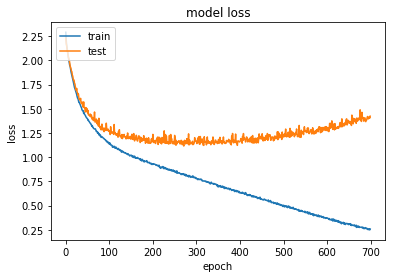

In [38]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Saving the model

In [39]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /home/therochvoices/Documents/CoreProject/saved_models/Emotion_Voice_Detection_Model.h5 


In [40]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Loading the model

In [36]:
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)

In [37]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Voice_Detection_Model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
acc: 92.22%


## Predicting emotions on the test data

In [38]:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

180/180 [==============================] - 0s 1ms/step


In [39]:
preds

array([[1.38203287e-03, 1.35085583e-02, 7.40133524e-02, ...,
        2.39207154e-10, 3.58950381e-08, 4.22595585e-05],
       [2.17852539e-06, 1.32769917e-09, 2.21676375e-11, ...,
        3.78589774e-03, 1.04146649e-03, 1.02831014e-04],
       [1.60865649e-03, 8.21916480e-03, 3.86192836e-02, ...,
        2.38939230e-10, 2.13196785e-08, 3.44450086e-06],
       ...,
       [3.57850216e-09, 5.93126867e-11, 5.25050489e-11, ...,
        9.76681173e-01, 2.02290453e-02, 5.38529770e-04],
       [2.55696442e-08, 2.55026459e-14, 3.60264769e-11, ...,
        1.01650665e-02, 6.09874666e-01, 1.57322162e-07],
       [2.07617887e-07, 5.93166988e-06, 1.78839432e-09, ...,
        1.04578608e-03, 1.18149899e-01, 8.10888946e-01]], dtype=float32)

In [40]:
preds1=preds.argmax(axis=1)

In [41]:
preds1

array([4, 5, 4, 8, 3, 6, 7, 6, 4, 1, 5, 7, 5, 2, 2, 6, 7, 2, 6, 9, 1, 2,
       5, 1, 6, 3, 3, 9, 1, 8, 1, 6, 4, 6, 6, 5, 4, 7, 5, 3, 6, 8, 0, 3,
       2, 6, 4, 1, 7, 0, 5, 2, 9, 9, 1, 3, 7, 5, 4, 4, 6, 4, 8, 9, 2, 8,
       8, 3, 9, 3, 9, 3, 1, 5, 3, 7, 8, 5, 2, 6, 8, 8, 4, 4, 4, 1, 5, 7,
       3, 8, 0, 7, 7, 6, 6, 2, 8, 0, 8, 5, 1, 4, 5, 1, 3, 4, 5, 1, 0, 2,
       3, 6, 2, 7, 9, 7, 1, 4, 2, 3, 3, 9, 8, 5, 7, 0, 5, 3, 5, 0, 1, 4,
       9, 2, 4, 0, 6, 4, 3, 4, 0, 6, 5, 9, 4, 5, 1, 4, 8, 5, 2, 9, 3, 9,
       2, 5, 9, 1, 6, 9, 8, 1, 8, 2, 7, 9, 1, 7, 5, 8, 9, 6, 9, 4, 9, 1,
       6, 7, 8, 9])

In [42]:
abc = preds1.astype(int).flatten()

In [43]:
predictions = (lb.inverse_transform((abc)))

/home/therochvoices/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [44]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,female_sad
1,male_angry
2,female_sad
3,male_happy
4,female_happy
5,male_calm
6,male_fearful
7,male_calm
8,female_sad
9,female_calm


In [45]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

/home/therochvoices/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [46]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,female_sad
1,male_angry
2,female_sad
3,male_happy
4,female_happy
5,male_calm
6,male_fearful
7,male_calm
8,female_sad
9,female_calm


In [47]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [48]:
finaldf[170:220]

,actualvalues,predictedvalues
170,male_sad,male_sad
171,male_calm,male_calm
172,male_sad,male_sad
173,female_sad,female_sad
174,male_sad,male_sad
175,female_calm,female_calm
176,male_calm,male_calm
177,male_fearful,male_fearful
178,male_angry,male_happy
179,male_sad,male_sad


In [49]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(actualdf, preddf)

In [50]:
matrix

array([[ 9,  0,  0,  2,  0,  0,  0,  0,  0,  0],
       [ 0, 17,  0,  1,  2,  0,  0,  0,  0,  0],
       [ 0,  1, 15,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  1, 15,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 20,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 22,  0,  1,  2,  0],
       [ 0,  0,  0,  0,  0,  0, 20,  0,  1,  1],
       [ 0,  0,  0,  0,  0,  0,  0, 15,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 14,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  1, 19]])

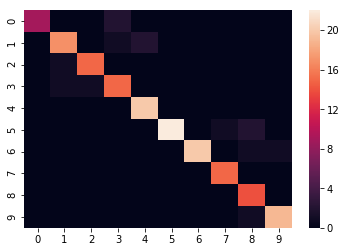

In [52]:
import seaborn as sns
ax = sns.heatmap(matrix)

In [129]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
female_angry,21
female_calm,20
female_fearful,19
female_happy,17
female_sad,20
male_angry,55
male_calm,25
male_fearful,55
male_happy,49


In [130]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,25
female_calm,22
female_fearful,19
female_happy,9
female_sad,25
male_angry,51
male_calm,29
male_fearful,51
male_happy,50


In [131]:
finaldf.to_csv('Predictions.csv', index=False)

# DEMO

In [179]:
mylist = os.listdir('testfiles/')

In [180]:
feeling_list=[]
for item in mylist:
    if item[6:-16]=='02' and int(item[18:-4])%2==0:
        feeling_list.append('female_calm')
    elif item[6:-16]=='02' and int(item[18:-4])%2==1:
        feeling_list.append('male_calm')
    elif item[6:-16]=='03' and int(item[18:-4])%2==0:
        feeling_list.append('female_happy')
    elif item[6:-16]=='03' and int(item[18:-4])%2==1:
        feeling_list.append('male_happy')
    elif item[6:-16]=='04' and int(item[18:-4])%2==0:
        feeling_list.append('female_sad')
    elif item[6:-16]=='04' and int(item[18:-4])%2==1:
        feeling_list.append('male_sad')
    elif item[6:-16]=='05' and int(item[18:-4])%2==0:
        feeling_list.append('female_angry')
    elif item[6:-16]=='05' and int(item[18:-4])%2==1:
        feeling_list.append('male_angry')
    elif item[6:-16]=='06' and int(item[18:-4])%2==0:
        feeling_list.append('female_fearful')
    elif item[6:-16]=='06' and int(item[18:-4])%2==1:
        feeling_list.append('male_fearful')
    elif item[:1]=='a':
        feeling_list.append('male_angry')
    elif item[:1]=='f':
        feeling_list.append('male_fearful')
    elif item[:1]=='h':
        feeling_list.append('male_happy')
    #elif item[:1]=='n':
        #feeling_list.append('neutral')
    elif item[:2]=='sa':
        feeling_list.append('male_sad')
labels = pd.DataFrame(feeling_list)

In [181]:
df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(mylist):
    if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08' and mylist[index][:2]!='su' and mylist[index][:1]!='n' and mylist[index][:1]!='d':
        X, sample_rate = librosa.load('RawData/'+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                            sr=sample_rate, 
                                            n_mfcc=13),
                        axis=0)
        feature = mfccs
        #[float(i) for i in feature]
        #feature1=feature[:135]
        df.loc[bookmark] = [feature]
        bookmark=bookmark+1   

In [182]:
df3 = pd.DataFrame(df['feature'].values.tolist())
newdf = pd.concat([df3,labels], axis=1)
rnewdf = newdf.rename(index=str, columns={"0": "label"})

rnewdf=rnewdf.fillna(0)

testfeatures = rnewdf.iloc[:, :-1]
testlabel = rnewdf.iloc[:, -1:]



X_test = np.array(testfeatures)
y_test = np.array(testlabel)

y_test = np_utils.to_categorical(lb.transform(y_test))

x_testcnn= np.expand_dims(X_test, axis=2)

opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)

# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Voice_Detection_Model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

preds1=preds.argmax(axis=1)
abc = preds1.astype(int).flatten()
#predictions = (lb.inverse_transform((abc)))
#preddf = pd.DataFrame({'predictedvalues': predictions})
predictions = (lb.inverse_transform((abc)))



Loaded model from disk
5/5 [==============================] - 0s 6ms/step


/home/therochvoices/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/therochvoices/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [183]:
preddf = pd.DataFrame({'predictedvalues': predictions})
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))
actualdf = pd.DataFrame({'actualvalues': actualvalues})

/home/therochvoices/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [184]:
finaldf = actualdf.join(preddf)

In [185]:
lb.classes_

array(['female_angry', 'female_calm', 'female_fearful', 'female_happy',
       'female_sad', 'male_angry', 'male_calm', 'male_fearful',
       'male_happy', 'male_sad'], dtype=object)

In [186]:
finaldf

,actualvalues,predictedvalues
0,male_fearful,male_sad
1,female_angry,female_angry
2,female_sad,female_calm
3,male_sad,male_sad
4,female_happy,female_happy
